En este notebook, entrenamos modelos de predicción de discursos de odio en base a distintos datasets, para poder predecir su uso en reddit.

In [1]:
import pickle

import pandas as pd
import spacy
import numpy as np

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from preprocessing_utils import preprocess_corpus



EMBEDDING = 'word2vec'  # valores posibles: 'lda', 'word2vec', 'fasttext'

TEXT_FILE_READ = 'docs/reddit_data_{}.csv'.format(EMBEDDING)
TEXT_FILE_GENERO = 'docs/analisis/genero.csv'
TEXT_FILE_SOBERANIA = 'docs/analisis/soberania.csv'

TEXT_SAVE_FILE = 'docs/reddit_data_hate_speech_' + EMBEDDING + '.csv'
TEXT_SAVE_FILE_POS_HATE_SPEECH = 'docs/test/reddit_data_hate_speech_pos_' + EMBEDDING + '.csv'
TEXT_SAVE_FILE_NEG_HATE_SPEECH = 'docs/test/reddit_data_hate_speech_neg_' + EMBEDDING + '.csv'

nlp = spacy.load("es_core_news_lg")

In [2]:
# cargamos un vectorizador y un modelo entrenado

with open('docs/models/meoffendmex_vectorizer.pkl', 'rb') as f:
    cv_meoffendmex = pickle.load(f)
    
with open('docs/models/meoffendmex_nb_model.pkl', 'rb') as f:
    nb_meoffendmex = pickle.load(f)

/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.24.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator ComplementNB from version 0.24.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Prueba de modelos en Reddit con MeOffendMex

In [3]:
df = pd.read_csv(TEXT_FILE_READ)

In [4]:
reddit_corpus = preprocess_corpus(df['body'].astype('str'))
reddit_adapted = cv_meoffendmex.transform(reddit_corpus)

In [5]:
reddit_predictions = nb_meoffendmex.predict(reddit_adapted)
reddit_hs_proba = nb_meoffendmex.predict_proba(reddit_adapted)[:,1]
print(reddit_hs_proba)

[0.00569818 0.9816972  0.10259367 ... 0.47363154 0.02588299 0.41293737]


In [6]:
target_predict_proba = 0.8
hate_mask = reddit_hs_proba>=target_predict_proba
non_hate_mask = reddit_hs_proba < target_predict_proba
print(len(hate_mask))

27791


In [7]:
df['hate_speech'] = df.apply(lambda row: '-' , axis = 1) 

for index,row in enumerate(df['body']):
    if reddit_hs_proba[index] >= target_predict_proba :
        is_hate_speech = 'si'
    else:
        is_hate_speech = 'no'
    df['hate_speech'][index] = is_hate_speech

<ipython-input-7-435dda9ac2e2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hate_speech'][index] = is_hate_speech


In [8]:
df.to_csv(TEXT_SAVE_FILE)

In [9]:
df[hate_mask].to_csv(TEXT_SAVE_FILE_POS_HATE_SPEECH)

In [10]:
df[non_hate_mask].to_csv(TEXT_SAVE_FILE_NEG_HATE_SPEECH)

# Predicción de los modelos en clústers de género y soberanía

### Cluster de genero

In [20]:
df_gen = pd.read_csv(TEXT_FILE_GENERO)

In [21]:
y_manual_gen = df_gen['hate_manual'] | df_gen['agresivo_manual'].values
y_pred_gen = df_gen['hate_speech'].apply(lambda x: 1 if x == 'si' else 0).values

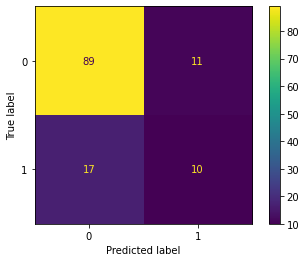

In [22]:
print(ConfusionMatrixDisplay.from_predictions(y_manual_gen, y_pred_gen))

In [23]:
print(classification_report(y_manual_gen, y_pred_gen))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       100
           1       0.48      0.37      0.42        27

    accuracy                           0.78       127
   macro avg       0.66      0.63      0.64       127
weighted avg       0.76      0.78      0.77       127



### Cluster de soberania

In [31]:
df_sn = pd.read_csv(TEXT_FILE_SOBERANIA)

In [32]:
y_manual_sn = df_sn['hate_manual'] | df_sn['agresivo_manual'].values
y_pred_sn = df_sn['hate_speech'].apply(lambda x: 1 if x == 'si' else 0).values

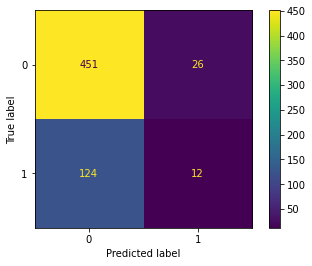

In [33]:
print(ConfusionMatrixDisplay.from_predictions(y_manual_sn, y_pred_sn))

In [34]:
print(classification_report(y_manual_sn, y_pred_sn))

              precision    recall  f1-score   support

           0       0.78      0.95      0.86       477
           1       0.32      0.09      0.14       136

    accuracy                           0.76       613
   macro avg       0.55      0.52      0.50       613
weighted avg       0.68      0.76      0.70       613



FIN